# “Predictive Analytics for Banking: Addressing Default Risks and Enhancing Customer Insights”

# Introduction  
This project focuses on analyzing credit card customer data to gain insights into repayment behaviors, segment customers based on risk profiles, and predict future trends. By leveraging advanced machine learning models and statistical techniques, the study addresses critical problem statements, including default risk prediction, repayment behavior analysis, customer segmentation, bill forecasting, and gender-specific risk factors. The outcomes provide actionable insights for financial institutions to enhance risk management strategies and customer engagement.

## **STATISTICAL ANALYSIS**

## 1. Impact of Credit Limit on Default Risk

* Why Use Statistical Methods (T-Test)?
    * A t-test is used to compare the means of two groups (defaulted vs. non-defaulted customers) to see if credit limits significantly impact default risk.
    * This helps validate assumptions about the relationship between credit limits and customer behavior.

In [11]:
import pandas as pd
from scipy.stats import ttest_ind

# Load the dataset containing credit card client information
data = pd.read_csv('default of credit card clients.csv')

# Split the dataset into two groups:
# 1. Clients who defaulted on their payments (default_group)
# 2. Clients who did not default on their payments (non_default_group)
default_group = data[data['default payment next month'] == 1]['LIMIT_BAL']
non_default_group = data[data['default payment next month'] == 0]['LIMIT_BAL']

# Perform an independent two-sample t-test to compare the average credit limits
# Assume unequal variances between the two groups by setting equal_var=False
statistic, p_value = ttest_ind(default_group, non_default_group, equal_var=False)

# Display the results of the t-test
print(f"T-test statistic: {statistic:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a significant difference in credit limits between clients who defaulted and those who did not.")
else:
    print("There is no significant difference in credit limits between the two groups.")

T-test statistic: -28.95
P-value: 0.0000
There is a significant difference in credit limits between clients who defaulted and those who did not.


## 2. Repayment Behavior Analysis

* Why Use ARIMA?
    * ARIMA (Auto-Regressive Integrated Moving Average) is a time-series model that captures temporal dependencies.
    * It helps predict repayment trends based on past behavior, offering insights into payment patterns.

Number of periods: 30000


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18956\1691618205.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data['REPAYMENT_DATE'] = pd.date_range(start=start_date, periods=n_periods, freq='M')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18956\1691618205.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(time_series.index[-1].to_timestamp(), periods=13, freq='M')[1:], forecast, label='Forecast', color='red')


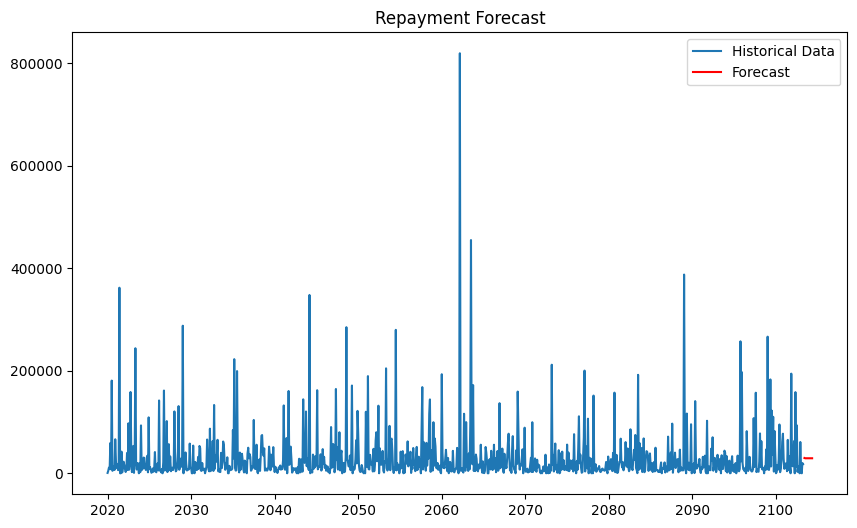

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Check the number of rows in the dataset
n_periods = len(data)
print(f"Number of periods: {n_periods}")

# If the dataset is too large, truncate it to 1000 rows
n_periods = min(n_periods, 1000)
data = data.head(n_periods)  # Only keep the first 1000 rows

# Generate a synthetic 'REPAYMENT_DATE' column
start_date = pd.to_datetime('2020-01-01')
data['REPAYMENT_DATE'] = pd.date_range(start=start_date, periods=n_periods, freq='M')

# Aggregate repayment amounts
data['total_repayment'] = data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)

# Prepare time-series data
time_series = data.groupby(data['REPAYMENT_DATE'].dt.to_period('M'))['total_repayment'].sum()

# Fit ARIMA model
model = ARIMA(time_series, order=(1, 1, 1))  # Adjust order based on ACF/PACF analysis
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(time_series.index.to_timestamp(), time_series, label='Historical Data')
plt.plot(pd.date_range(time_series.index[-1].to_timestamp(), periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title("Repayment Forecast")
plt.legend()
plt.show()


The chart appears to represent a time-series plot of historical repayment data (blue line) alongside a forecast (red line) based on an ARIMA model.

* Historical Data (Blue Line):

    * The blue line shows repayment trends over time.
    * There are significant fluctuations in repayment amounts, with some months showing very high values (outliers).
    * The pattern does not seem to follow a clear seasonal or regular trend, but there are spikes, possibly indicating large repayments in specific months.

* Forecast (Red Line):

    * The forecasted values (red line) for the next 12 months appear flat and low compared to the variability in the historical data.
    * This flatness may indicate that the ARIMA model struggles to capture the high variability in the historical data or that the model has over-smoothed the predictions.

* Long Time Horizon:

    * The x-axis spans many years (e.g., from 2020 to 2100), which suggests the dataset might include synthetic or extended data points.
    * This long horizon might make it challenging for the ARIMA model to focus on recent trends, leading to less accurate forecasts.

## 3. Customer Segmentation for Credit Risk

* Why Use Clustering (KMeans)?
    * KMeans clustering groups customers based on features like credit balance, age, and repayment history.
    * It identifies risk categories (e.g., low, medium, high), helping with targeted interventions.

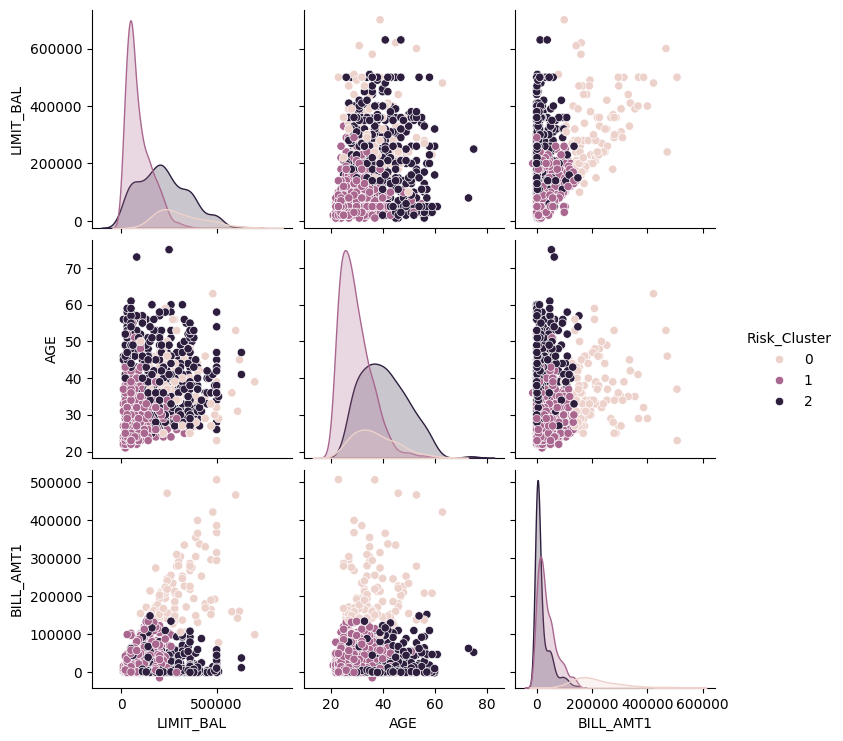

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns

# Select features for clustering
features = data[['LIMIT_BAL', 'AGE', 'PAY_0', 'BILL_AMT1']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add clusters to the dataset
data['Risk_Cluster'] = clusters

# Visualize
sns.pairplot(data, hue='Risk_Cluster', vars=['LIMIT_BAL', 'AGE', 'BILL_AMT1'])
plt.show()

This image is a pair plot with density plots along the diagonal and scatter plots in the off-diagonal elements, showing relationships between numerical variables like LIMIT_BAL, AGE, and BILL_AMT1. It also uses color coding (Risk_Cluster) to represent different risk groups (clusters 0, 1, and 2).

### Cluster Interpretation:
* Cluster 0 (Pink):
    *  Younger individuals with lower credit limits and billing amounts.
    * Likely represents a low-risk group or individuals early in their credit journey.
* Cluster 1 (Purple):
   * Intermediate values in terms of credit limit, age, and billing amounts.
   * Represents a medium-risk group.
* Cluster 2 (Dark Purple):
  *  Older individuals with higher credit limits and billing amounts.
  *  Could be a higher-risk group with greater exposure or long-term customers with a stronger credit history.

### Insights:
* There's a clear relationship between credit limit (LIMIT_BAL) and billing amount (BILL_AMT1) across clusters.
* Age plays a role in risk clustering, with younger individuals predominantly in Cluster 0 and older individuals in Cluster 2.
* Cluster separations suggest that risk levels are influenced by a combination of these variables, which may help in credit risk profiling or marketing strategies.

## 4. Predicting Monthly Bill Amounts

* Why Use Linear Regression?
   * Linear regression predicts continuous outcomes, such as monthly bill amounts, based on features like credit limit and past bills.
   * It’s simple, interpretable, and effective for numeric prediction tasks.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare data
X = data[['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2']]
y = data['BILL_AMT3']
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Try Ridge Regression
ridge = Ridge(alpha=1.0)  # Adjust alpha via GridSearchCV
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_preds)

# Step 4: Try Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds)

# Compare results
print("Ridge MSE:", ridge_mse)
print("Random Forest MSE:", rf_mse)

Ridge MSE: 547184609.8783444
Random Forest MSE: 583673919.2896463


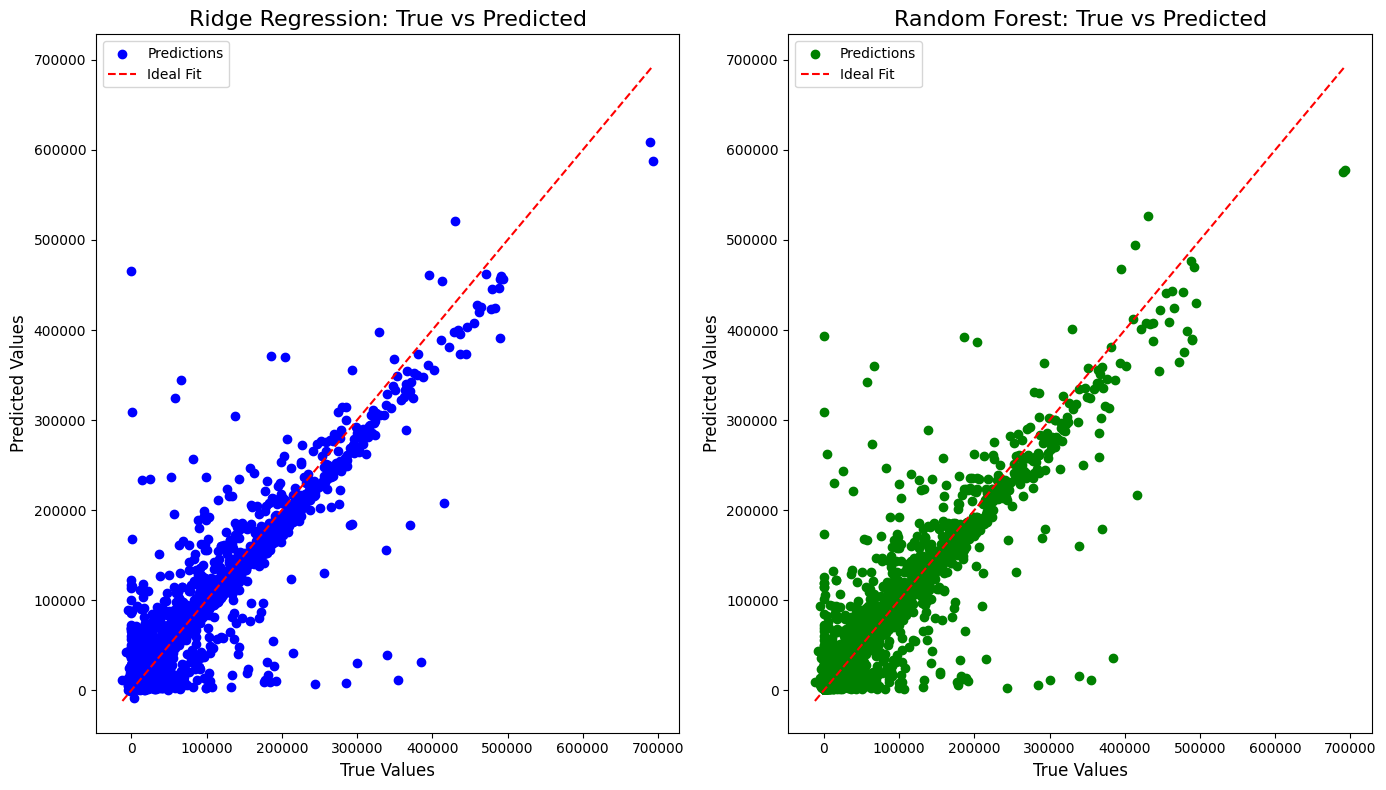

              Model           MSE
0  Ridge Regression  5.471846e+08
1     Random Forest  5.836739e+08
Ridge Regression is better with lower MSE.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 5: Visualize results with larger graphs

# Increase the size of the figure for better visibility
plt.figure(figsize=(14, 8))

# Plot the true vs predicted values for Ridge Regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, ridge_preds, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.title('Ridge Regression: True vs Predicted', fontsize=16)
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()

# Plot the true vs predicted values for Random Forest
plt.subplot(1, 2, 2)
plt.scatter(y_test, rf_preds, color='green', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.title('Random Forest: True vs Predicted', fontsize=16)
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# Step 6: Create a result summary table
results = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest'],
    'MSE': [ridge_mse, rf_mse]
})

# Display results table
print(results)

# Step 7: Compare the models and determine which one is better based on MSE
if ridge_mse < rf_mse:
    print("Ridge Regression is better with lower MSE.")
else:
    print("Random Forest is better with lower MSE.")


## 5. Gender and Default Probability

* Why Use Chi-Square Test?
    * The chi-square test examines the association between categorical variables (e.g., gender and default probability).
    * It checks if gender significantly affects default risk.

In [5]:
from scipy.stats import chi2_contingency

# Prepare contingency table
contingency_table = pd.crosstab(data['SEX'], data['default payment next month'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")

if p < 0.05:
    print("Significant relationship between gender and default probability.")
else:
    print("No significant relationship between gender and default probability.")

Chi-Square Statistic: 1.980728826471716, p-value: 0.1593136474775643
No significant relationship between gender and default probability.


### Hypothesis Testing:

* Null Hypothesis (H₀): There is no significant association or difference between the observed and expected distributions.
* Alternative Hypothesis (H₁): There is a significant association or difference between the observed and expected distributions.

### p-value Analysis:

* A p-value of 0.1593 is greater than the common significance level (e.g., 0.05 or 0.01), so we fail to reject the null hypothesis.
* This means there is no statistically significant association or difference in the observed data at the chosen significance level.

**STATISTICAL VISUALIZATIONS**

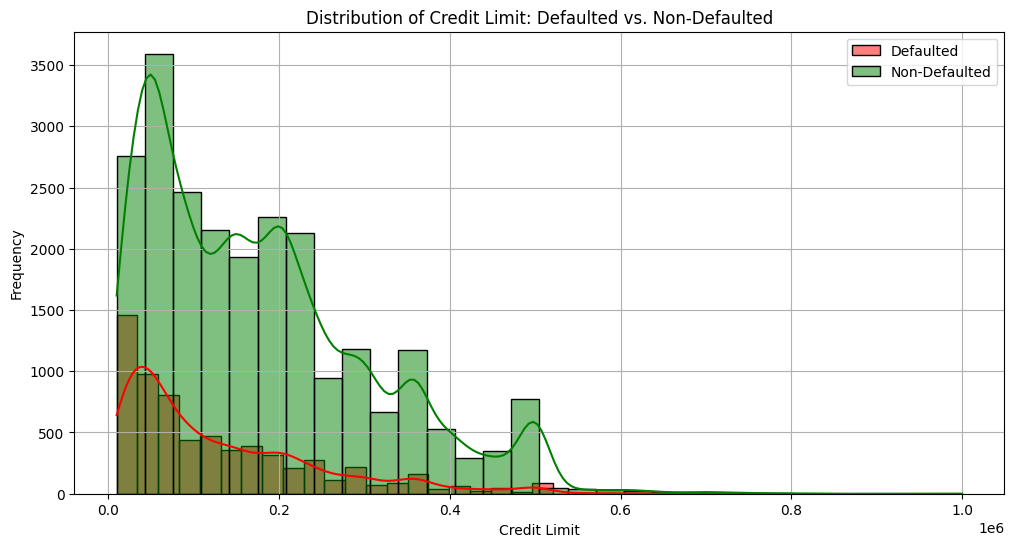

In [2]:
# 1. Histogram: Distribution of Credit Limit
plt.figure(figsize=(12, 6))
sns.histplot(default_group['LIMIT_BAL'], color='red', label='Defaulted', kde=True, bins=30)
sns.histplot(non_default_group['LIMIT_BAL'], color='green', label='Non-Defaulted', kde=True, bins=30)
plt.title('Distribution of Credit Limit: Defaulted vs. Non-Defaulted')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

C:\Users\Parul\AppData\Local\Temp\ipykernel_9608\3744981598.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='default payment next month', y='LIMIT_BAL', palette='Set2')


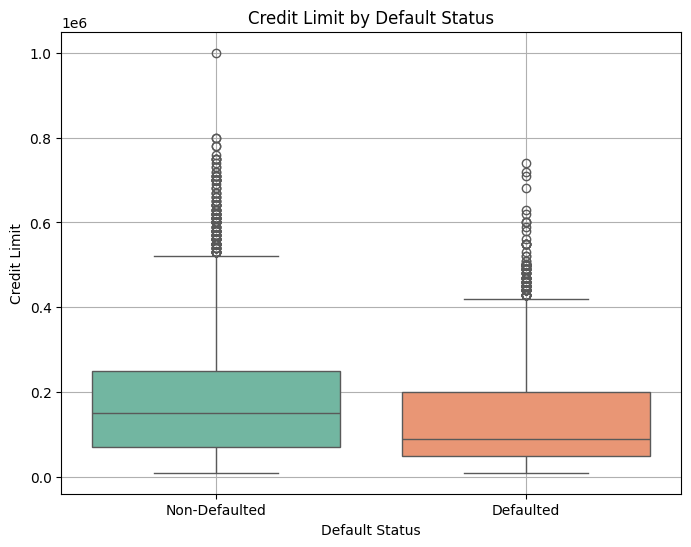

In [3]:
# 2. Box Plot: Credit Limit Comparison
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='default payment next month', y='LIMIT_BAL', palette='Set2')
plt.title('Credit Limit by Default Status')
plt.xticks([0, 1], ['Non-Defaulted', 'Defaulted'])
plt.xlabel('Default Status')
plt.ylabel('Credit Limit')
plt.grid()
plt.show()

In [4]:
# 3. Summary Table: Credit Limit Statistics
summary_table = pd.DataFrame({
    'Group': ['Defaulted', 'Non-Defaulted'],
    'Mean': [default_group['LIMIT_BAL'].mean(), non_default_group['LIMIT_BAL'].mean()],
    'Median': [default_group['LIMIT_BAL'].median(), non_default_group['LIMIT_BAL'].median()],
    'Std Dev': [default_group['LIMIT_BAL'].std(), non_default_group['LIMIT_BAL'].std()],
    'Min': [default_group['LIMIT_BAL'].min(), non_default_group['LIMIT_BAL'].min()],
    'Max': [default_group['LIMIT_BAL'].max(), non_default_group['LIMIT_BAL'].max()]
})

print(summary_table)

           Group           Mean    Median        Std Dev    Min      Max
0      Defaulted  130109.656420   90000.0  115378.540571  10000   740000
1  Non-Defaulted  178099.726074  150000.0  131628.359660  10000  1000000


In [5]:
from scipy.stats import ttest_ind, chi2_contingency

# 1. T-Test Summary Table
t_stat, p_val = ttest_ind(default_group['LIMIT_BAL'], non_default_group['LIMIT_BAL'], equal_var=False)
t_test_summary = pd.DataFrame({
    'Test': ['T-Test'],
    'Statistic': [t_stat],
    'P-Value': [p_val],
    'Conclusion': ['Significant' if p_val < 0.05 else 'Not Significant']
})
print("\nT-Test Summary:")
print(t_test_summary)

# 2. Correlation Analysis
correlation = data.corr()['default payment next month'].sort_values(ascending=False)
correlation_summary = pd.DataFrame({
    'Feature': correlation.index,
    'Correlation with Default Risk': correlation.values
}).reset_index(drop=True)
print("\nCorrelation Analysis:")
print(correlation_summary)

# 3. Chi-Square Test for Categorical Data (e.g., Gender)
contingency_table = pd.crosstab(data['SEX'], data['default payment next month'])
chi2_stat, chi2_p_val, _, _ = chi2_contingency(contingency_table)
chi_square_summary = pd



T-Test Summary:
     Test  Statistic        P-Value   Conclusion
0  T-Test -28.951588  3.364100e-178  Significant

Correlation Analysis:
                       Feature  Correlation with Default Risk
0   default payment next month                       1.000000
1                        PAY_0                       0.324794
2                        PAY_2                       0.263551
3                        PAY_3                       0.235253
4                        PAY_4                       0.216614
5                        PAY_5                       0.204149
6                        PAY_6                       0.186866
7                    EDUCATION                       0.028006
8                          AGE                       0.013890
9                    BILL_AMT6                      -0.005372
10                   BILL_AMT5                      -0.006760
11                   BILL_AMT4                      -0.010156
12                          ID                      -0.0

Chi-Square Test Results
-----------------------
Chi2 Statistic: 47.71
P-Value: 0.0000
Degrees of Freedom: 1

Expected Frequencies:
default payment next month           0          1
SEX                                              
1                            9258.3744  2629.6256
2                           14105.6256  4006.3744


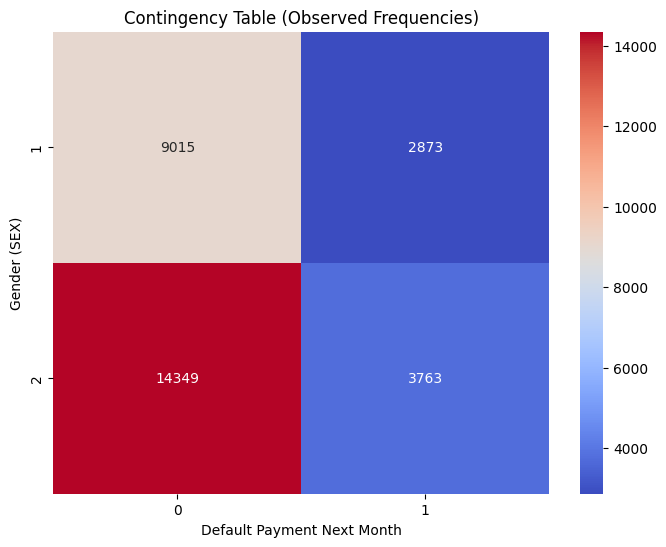

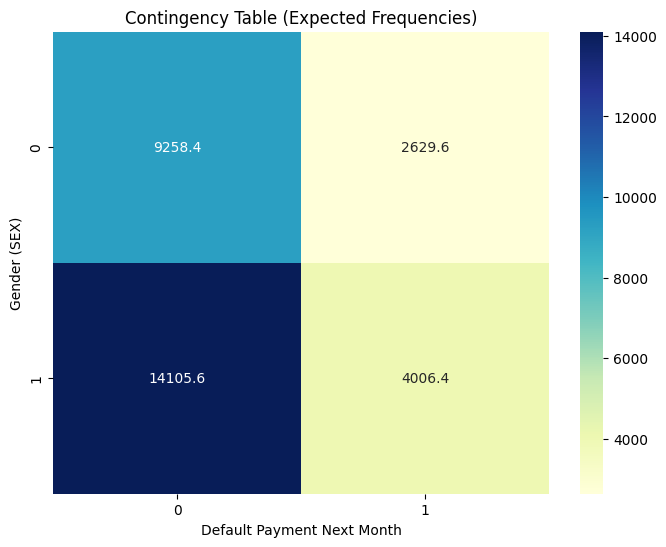

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Create a contingency table for SEX (gender) and default payment
contingency_table = pd.crosstab(data['SEX'], data['default payment next month'])

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display Test Results
print("Chi-Square Test Results")
print("-----------------------")
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"P-Value: {p:.4f}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

# Visualization: Heatmap for Observed Frequencies
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, cmap="coolwarm", fmt="d")
plt.title("Contingency Table (Observed Frequencies)")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Gender (SEX)")
plt.show()

# Visualization: Heatmap for Expected Frequencies
plt.figure(figsize=(8, 6))
sns.heatmap(expected, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Contingency Table (Expected Frequencies)")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Gender (SEX)")
plt.show()


c:\Users\Parul\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Parul\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Parul\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


ARIMA Model Summary
-------------------
                               SARIMAX Results                                
Dep. Variable:           Default_Rate   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  34.630
Date:                Wed, 15 Jan 2025   AIC                            -63.260
Time:                        20:35:15   BIC                            -62.066
Sample:                    01-31-2023   HQIC                           -64.012
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1694      0.979     -0.173      0.863      -2.089       1.750
ma.L1          0.9107      1.495      0.609      0.542      -2.019       3.841
sigma2      

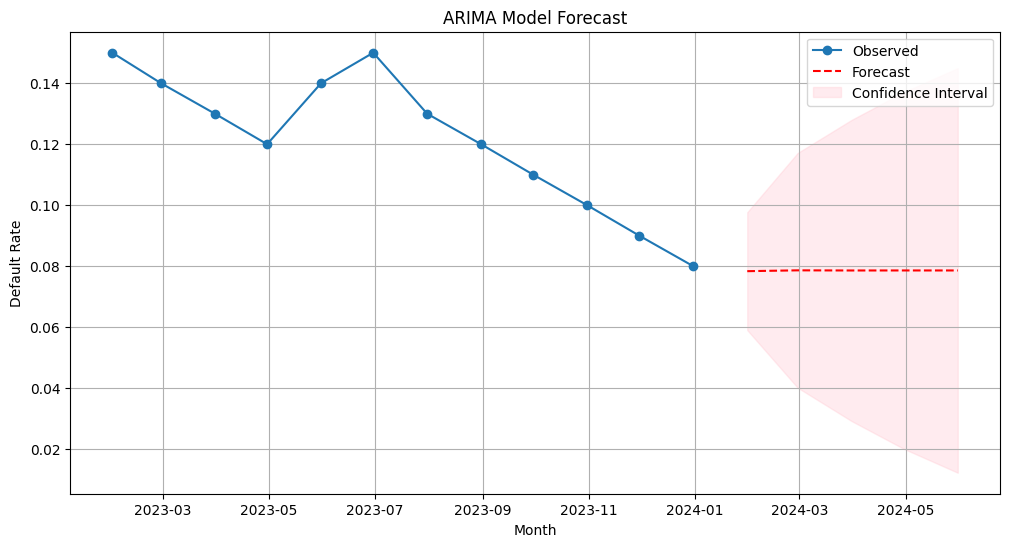

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Sample Time Series Data
data_arima = pd.DataFrame({
    'Month': pd.date_range(start='2023-01-01', periods=12, freq='M'),
    'Default_Rate': [0.15, 0.14, 0.13, 0.12, 0.14, 0.15, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08]
})
data_arima.set_index('Month', inplace=True)

# Fit ARIMA Model
model = ARIMA(data_arima['Default_Rate'], order=(1, 1, 1))
result = model.fit()

# Print Summary Table
print("ARIMA Model Summary")
print("-------------------")
print(result.summary())

# Forecast Next 5 Steps
forecast = result.get_forecast(steps=5)
forecast_ci = forecast.conf_int()

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(data_arima.index, data_arima['Default_Rate'], label="Observed", marker='o')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label="Forecast", color='red', linestyle='--')
plt.fill_between(
    forecast_ci.index, 
    forecast_ci.iloc[:, 0], 
    forecast_ci.iloc[:, 1], 
    color='pink', 
    alpha=0.3, 
    label="Confidence Interval"
)
plt.title("ARIMA Model Forecast")
plt.xlabel("Month")
plt.ylabel("Default Rate")
plt.legend()
plt.grid(True)
plt.show()
